## FEtaure extraction

In [1]:
import os
import cv2
import json
import glob
import numpy as np
import seaborn as sns
from tqdm import tqdm
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from skimage.measure import euler_number
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [2]:
tools = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro','nastro', 'pappagallo', 'penna', 'spillatrice']
feat_euler, feat_mean, feat_perimeter, feat_axis = [], [], [], []
y_labels = []

# Caricamento dell'immagine segmentata
cwd = os.getcwd()
folder_path = os.path.join(cwd, f"images")

for tool in tqdm(tools):

    with open(f"{folder_path}\{tool}\{tool}_gt.json", 'r') as f:
        ground_truth_file = json.load(f)

    for pos, el in enumerate(ground_truth_file):

        truth_mask = np.zeros((520, 520))
        image = cv2.imread(f"{folder_path}\{tool}\{tool}_{pos+1}.png")
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        for i in range(len(ground_truth_file[el]['regions'])):

            x_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_x']
            y_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_y']
            vertices = np.array([[x_pos[u], y_pos[u]] for u in range(len(x_pos))])
            if i == 0:
                    cv2.fillPoly(truth_mask, [vertices], 255)
            else:
                    cv2.fillPoly(truth_mask, [vertices], 0)

        # Ground truth.
        x_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_x']
        y_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_y']
        vertices = np.array([[x_pos[i], y_pos[i]] for i in range(len(x_pos))])
        truth_mask = truth_mask.astype(bool)

        # Immagine segmentata.
        segmented = np.zeros_like(image)
        segmented[truth_mask] = image[truth_mask]
        

        ## Estrazione delle Features.

        # Numero di Eulero.
        euler = euler_number(segmented)

        # Media pixel segmentati.
        mu = np.mean(segmented) / 520

        # Lunghezza del perimetro.
        if len(segmented.shape) > 2:
            binary_mask = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = cv2.arcLength(contours[0], True) / 520

        # Rapporto assi ellisse.
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(largest_contour)
        major_axis, minor_axis = ellipse[1]
        axis_ratio = major_axis / minor_axis / 520


        y_labels.append(tool)
        feat_euler.append(euler)
        feat_mean.append(mu)
        feat_perimeter.append(perimeter)
        feat_axis.append(axis_ratio)


all_features = np.column_stack((feat_euler, feat_mean, feat_perimeter, feat_axis))

100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


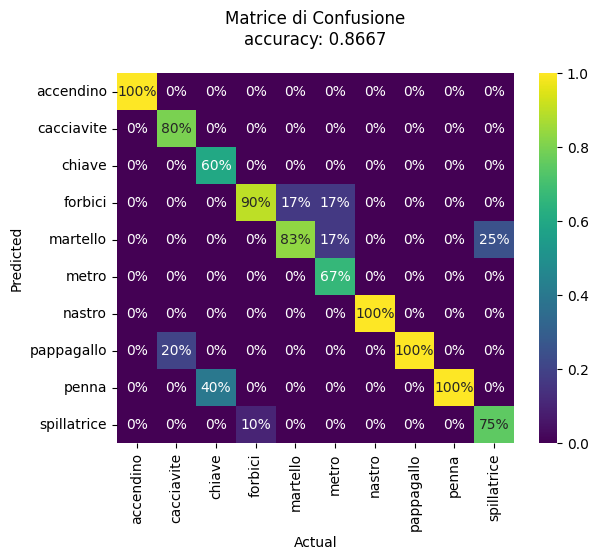

In [3]:
# Dati.
X = all_features
y = y_labels

# Dividiamo il dataset in train e test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modello utilizzato per la calssificazione.
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Prediacimo le y per i dati di test.
y_pred = clf.predict(X_test)

# Valutazione della precisione del modello.
accuracy = accuracy_score(y_test, y_pred)

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
cm = np.array(cm)
col_sums = cm.sum(axis=0)
cm = cm / col_sums[np.newaxis, :]
sns.heatmap(cm, annot=True, cmap='viridis', xticklabels=tools, yticklabels=tools, fmt=".0%")
plt.title(f"Matrice di Confusione\naccuracy: {round(accuracy, 4)}\n")
plt.xlabel('Actual')
plt.ylabel('Predicted');